# Simulating a model with CoLoMoTo toolbox

## Simulations and analyses of a model of signalling pathways in cancer

* Docker
Docker and Python need to be pre-installed, go to your folder and then type in a terminal:

```
colomoto-docker -V latest --bind .
```

This notebook can be launched using the Docker image of CoLoMoTo:
```
   docker pull colomoto/colomoto-docker:latest
```

* Conda environment
You can also create a conda environment with the following command:

```
    conda create -n myenv -c colomoto ginsim-python pymaboss -c potassco
```

To launch this notebook, type the command:
```
    jupyter notebook
```
Note that some software are not optimal on MacOS. In this case, we suggest to use the docker.

The purpose of this notebook is to reproduce some of the results of an article from Sizek et al. on the role of the PI3K/AKT signalling pathway in aberrant cell cycle progression, using the tools available in CoLoMoTo and suggest additional analyses that were not performed in the initial publication. 

The reference of the model studied here is the following: 
Sizek H, Hamel A, Deritei D, Campbell S, Ravasz Regan E (2019) Boolean model of growth signaling, cell cycle and apoptosis predicts the molecular mechanism of aberrant cell cycle progression driven by hyperactive PI3K. PLOS Computational Biology 15(3): e1006402. https://doi.org/10.1371/journal.pcbi.1006402

## Loading required packages

Before running the analyses, we load the packages that will be used.

In [1]:
import numpy as np
import seaborn as sns

import ginsim
import biolqm
import maboss
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states
import pydot

import os

from tools import load_trajs, draw_graph_from_pandas, compute_circuits, compute_stg_counts

The analyses that will be performed in this notebook are the following:

    * Visualization of the network with GINsim
    * Sequence of events: cyclins' activation

## Visualization of the network with GINsim

We used bioLQM to import the original model, then we updated the model layout in GINsim. The resulting model has the same logical rules as the original one and can be found in the GINsim repository at the address: http://ginsim.org/node/XX

To load the model and visualize the GINsim network, we run the following functions:

In [2]:
model_ginsim = ginsim.load("Sizek_PI3K_cell_cycle_apoptosis_PCB_2019.zginml")
ginsim.show(model_ginsim)

In [3]:
def read_state(state_file):
    state = {}
    with open(state_file) as f:
        for line in f:
            line = line.strip().split()
            if len(line) == 2:
                state[ line[0] ] = int(line[1])
    return state

init = read_state("cell_cycle_init.txt")

In [4]:
# convert to biolqm
model_biolqm = ginsim.to_biolqm(model_ginsim) 

## MaBoSS simulation of the wild type model

In this section, we focus on MaBoSS analyses. MaBoSS performs stochastic simulations over the Boolean networks and considers continuous time. The software outputs time trajectories and probabilities can be assigned to model states over time. This analysis aims to complement the interpretation of results that are provided in the initial paper and offer a semi-quantitative understanding of the obtained results. Also, MaBoSS can follow the simulations over time using an asynchronous, which permits the identification of transient behaviours, such as transient cycles as it is the case here.

The MaBoSS model can be obtained directly from bioLQM.

In [5]:
model_maboss = biolqm.to_maboss(model_biolqm) # convert to maboss

We can load the model and modify some configuration parameters. Note that if you used the export of GINsim export, all the initial values will be set to 0. In our case, we will assign the initial conditions that are defined in the article.

In [6]:
model_maboss.update_parameters(sample_count=5000,max_time=200, time_tick=0.5, thread_count=6)

We have defined the maBoSS model with the following simulation parameters: 
- number of simulations: 5000
- maximum length of the simulation (in arbitrary unit): 200
- interval between two time points: 0.5

These parameters will be used for all versions of the models (wild type, different initial conditions, mutants, etc.) for the rest of the study.

Next, we define a wild type version of the model called WT and select the exteernal variables (i.e., the variables on which we will focus for the simulations)

In [7]:
WT = model_maboss.copy()

## Select outputs for visualisation of the results
WT.network.set_output(('CyclinB','Casp3','PI3K_H','E2F1','Replication','p21', 'RTK'))

### Study different sets of initial conditions 

We set the initial condition as it is indicated in the article. We have defined previously an object called "init" that sets the initial conditions for each of the entities of the model.

In [8]:
## Conditions of Fig. 5 of Sizek et al.
active_init = [ k for (k,v) in init.items() if v==1 ]
maboss.set_nodes_istate(WT, active_init, [0,1])

We can visualize the results either as time trajectories following the probability of the model states (vector of active nodes), and of the nodes (found active) over time, or as asymptotic solutions by focusing only on the probabilities of the model states obtained at the end of the simulations, i.e., 200 a.u.

Text(0.5, 1.0, 'WT pie chart')

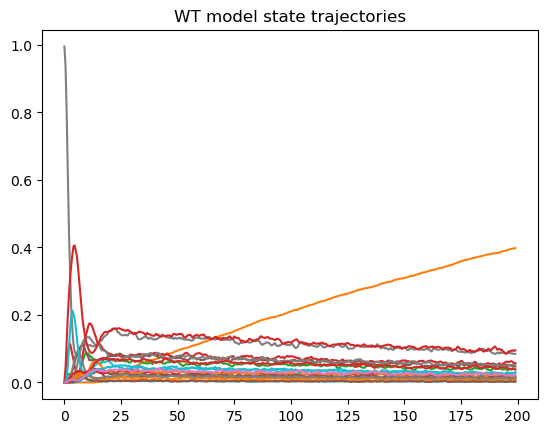

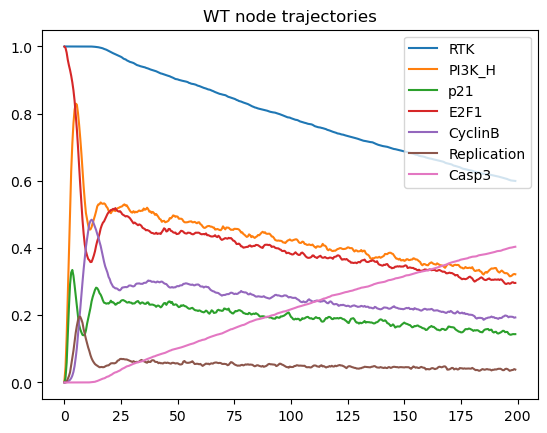

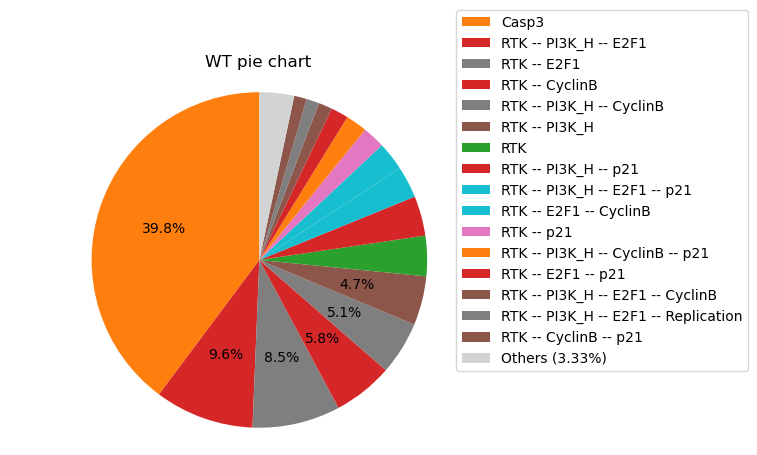

In [9]:
## Run a MaBoSS simulation
run_WT = WT.run()

## Plot the trajectories of the WT simulation with model states
run_WT.plot_trajectory(legend=False)
plt.title('WT model state trajectories')

## Plot the trajectories of the WT simulation with selected nodes
run_WT.get_nodes_probtraj().plot(legend=True)
plt.title('WT node trajectories')

## Note that the model state <nil> means that none of the external variables are ON. 

# Plot pie chart
run_WT.plot_piechart()
plt.title('WT pie chart')

The simulations clearly show that there are some transient limit cycles that will eventually be switched off by the activation of Casp3

We can also plot the entropy (H) and the transition entropy (TH) of the simulations.

Text(0.5, 1.0, 'WT entropy')

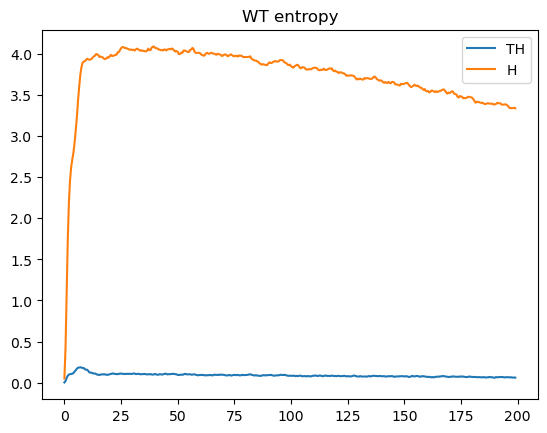

In [10]:
run_WT.plot_entropy_trajectory()
plt.title('WT entropy')

The transition entropy will slowly reach 0, confirming the existence of transient limit cycles.

### Set initial conditions: TRAIL ON

In the previous initial condition, the death signals were OFF. We study the effect of activating the death pathways by activating TRAIL on top of the initial conditions defined above.

In [11]:
WT_death = WT.copy()
maboss.set_nodes_istate(WT_death, ["Trail" ] + active_init, [0,1])

Text(0.5, 1.0, 'WT death signal ON')

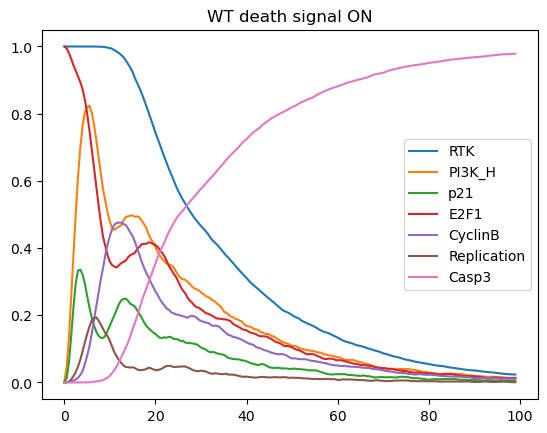

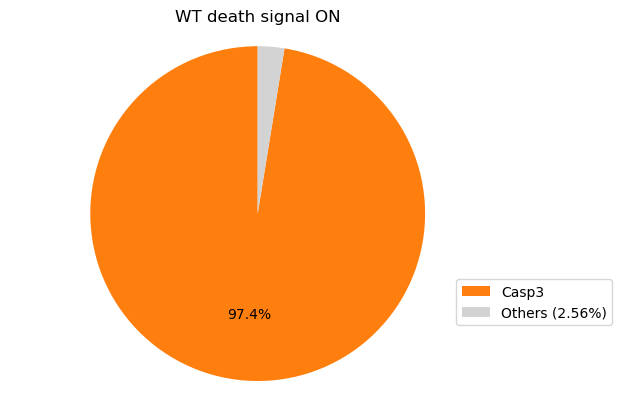

In [12]:
## Run a MaBoSS simulation
WT_death.update_parameters(sample_count=5000,max_time=100, time_tick=0.5)
run_WT_death = WT_death.run()

## Plot the results of the WT simulation
#run_WT_death.plot_trajectory(legend=False)
run_WT_death.get_nodes_probtraj().plot(legend=True)
plt.title('WT death signal ON')

# Plot pie chart
run_WT_death.plot_piechart()
plt.title('WT death signal ON')

Casp3 ias activated faster than in the previous setting, reaching a death stable phenotype faster.

Text(0.5, 1.0, 'WT death entropy')

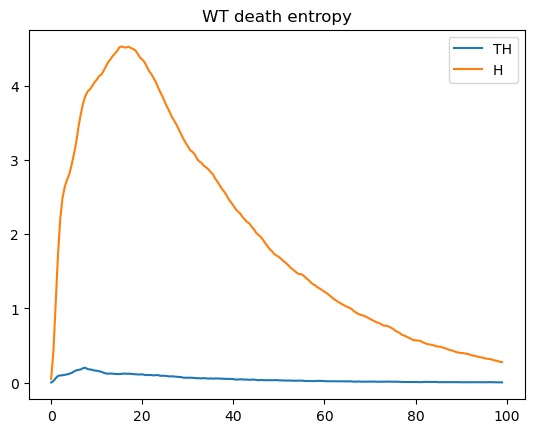

In [13]:
run_WT_death.plot_entropy_trajectory()
plt.title('WT death entropy')

Similarly, the TH reaches 0 faster than in the previous simulations showing that the exit of cell cycle occurs faster in the presence of TRAIL.

## Mutant simulations 

It is also possible to simulate knockouts or overexpressions of some entities of the model that could mimick a gene mutation or a drug treatment. We show two cases here, the first one is a gain of function and the second one is a loss of function. It is possible to combine mutations and create double or triple mutations (not shown here) by incrementally add a mutation to an already mutated variant of the WT model. 

In [14]:
#WT.update_parameters(sample_count=5000,max_time=100, time_tick=0.5)

#### Experiment 1: Casp8 overexpression

We first test some gain of function to explore the model's dynamics. Here we try to force Casp8 in the case that TRAIL is OFF

Text(0.5, 1.0, 'Casp8 mutant')

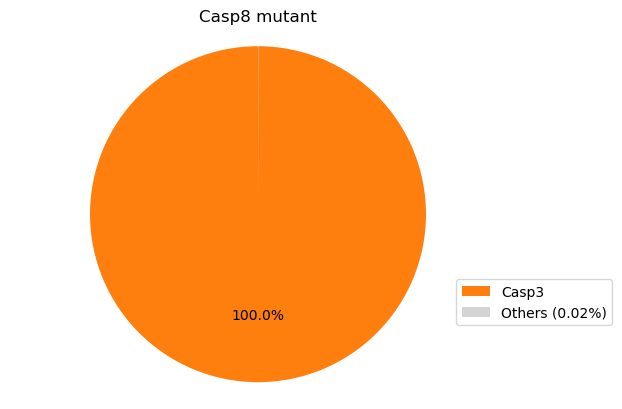

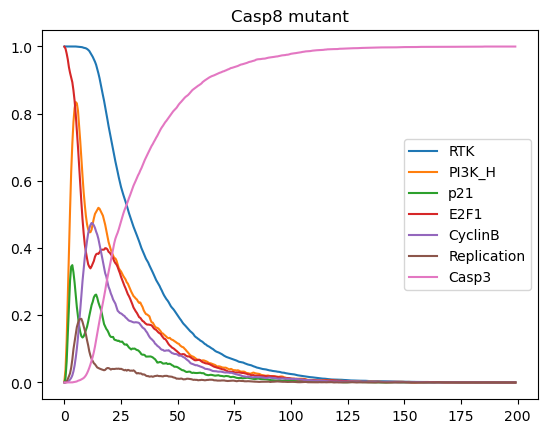

In [15]:
## Gain of function for node 1
mut_Casp8_ON = WT.copy()
mut_Casp8_ON.mutate("Casp8", "ON")
mutres_Casp8_ON = mut_Casp8_ON.run()
mutres_Casp8_ON.plot_piechart()
plt.title('Casp8 mutant')
mutres_Casp8_ON.get_nodes_probtraj().plot(legend=True)
plt.title('Casp8 mutant')

The overexpression of Casp8 forces the cells into apoptosis faster no matter if TRAIL is ON or OFF.

#### Experiment 2: Casp8 deletion

We simulate a loss of function of Casp8 when TRAIL is OFF

Text(0.5, 1.0, 'CASP8 mutant')

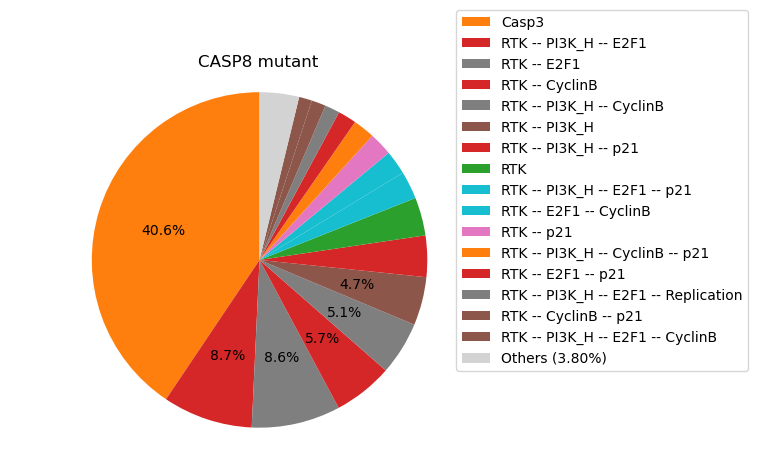

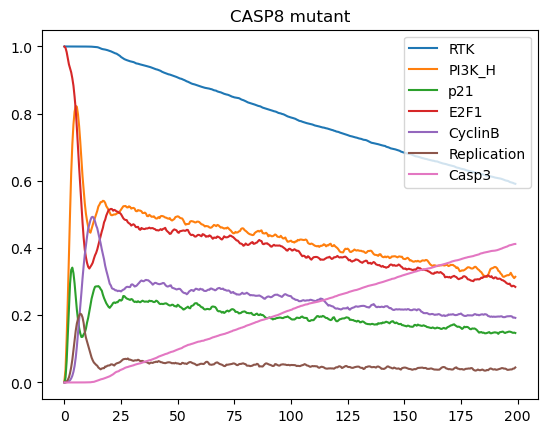

In [16]:
## Loss of function for node 2
mut_CASP8_OFF = WT.copy()
#mut_CASP8_OFF.update_parameters(max_time=150, time_tick=0.5)
mut_CASP8_OFF.mutate("Casp8", "OFF")
mutres_CASP8_OFF = mut_CASP8_OFF.run()
mutres_CASP8_OFF.plot_piechart()
plt.title('CASP8 mutant')
mutres_CASP8_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('CASP8 mutant')

The apoptosis is initially blocked but can eventually be activated as it is the case in wild type. Casp8 deletion has no effect on the simulations. The activation of Casp3 seems to be independent of the status of Casp8.

### Table 3: model validation on experimentally published results

We selected some simulations of already reported mutations and focused on the role of Plk1 and PI3K.

These are the results presented in Table 3 of Sizek et al.. 

(1) complete absence of Plk1 leads to a G2 arrest.
What is the difference between complete absence and Plk1 knock down? In our case, the two experiments are simulated the same way. 

(2) strong Plk1 ko leads to mitotic arrest, mitotic catastrophe and apoptosis

(3) moderate Plk1 ko causes premature, aberrant anaphase, aneuploidy and genome duplication

(4) weak Plk1 ko leads to no cytokinesis and genome duplication

(5) forced p110H leads to no cytokinesis

(6) forced PI3KH leads to no cytokinesis

(7) forced PI3KH and AKTH increases rate of proliferation in low GF envrionments

(8) partial FoxO3 ko leads to no cytokinesis

(9) strong FoxO3 ko leads to decrease in PI3K/AKT signaling and slows down proliferation


What we wish to do is not to reproduce all these results but few examples and interpret the results using MaBoSS simulations.

#### (1-2) Strong loss of function for Plk1 before prometaphase

Text(0.5, 1.0, 'Plk1 mutant')

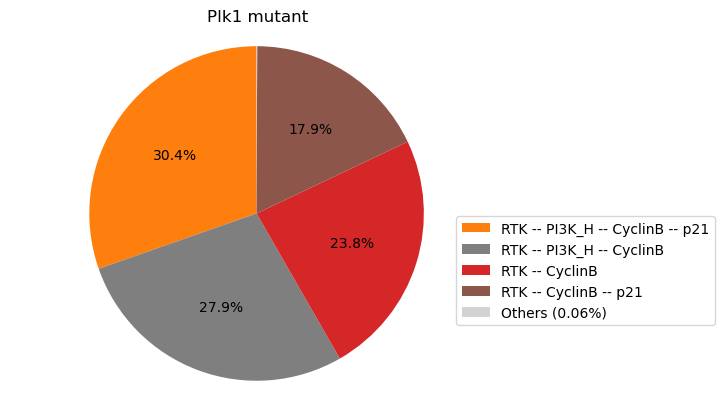

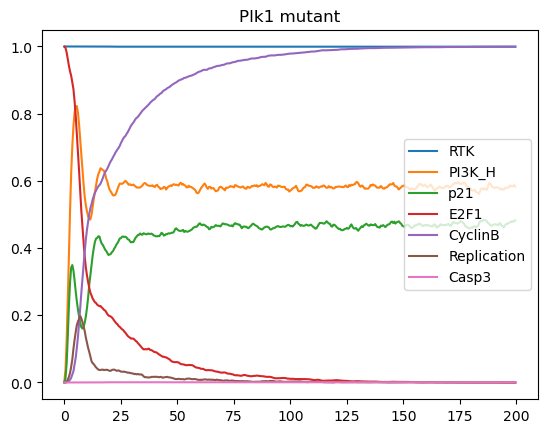

In [17]:
mut_Plk1_OFF = WT.copy()

mut_Plk1_OFF.mutate("Plk1", "OFF")
mutres_Plk1_OFF = mut_Plk1_OFF.run()
mutres_Plk1_OFF.plot_piechart()
plt.title('Plk1 mutant')
mutres_Plk1_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('Plk1 mutant')

It seems that CyclinB is present in most of the states, which indicates that the cycle is probably stuck in G2, and which confirms what is expected from the model and the experimental observations. In these conditions, there is no apoptosis triggered. 

#### (6) PI3K over expression

Text(0.5, 1.0, 'PI3K mutant')

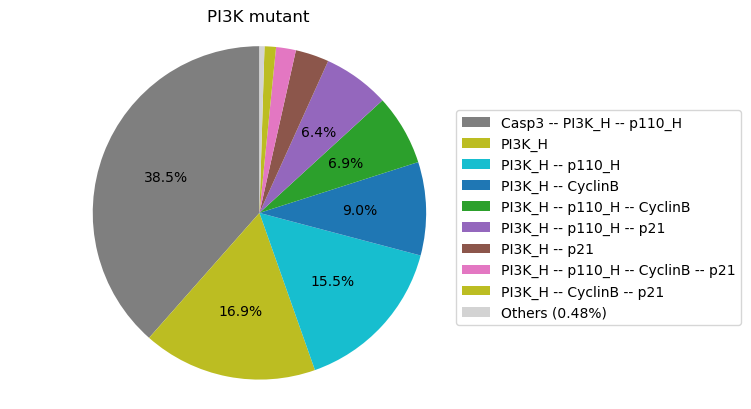

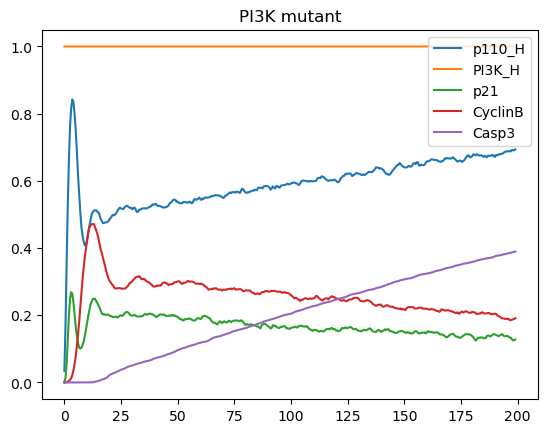

In [18]:
mut_PI3K_ON = WT.copy()
mut_PI3K_ON.network.set_output(('CyclinB','Casp3','PI3K_H','p21', 'p110_H'))
mut_PI3K_ON.mutate("PI3K_H", "ON")
mutres_PI3K_ON = mut_PI3K_ON.run()
mutres_PI3K_ON.plot_piechart()
plt.title('PI3K mutant')
mutres_PI3K_ON.get_nodes_probtraj().plot(legend=True)
plt.title('PI3K mutant')

We force PI3K at its highest value (always ON). The simulations show a similar output as the wild type. In our case, it is difficult to conclude that there is no cytokinesis as it is reported in Table 3.

Figure 8 mentions the double alteration p110_H and PI3K_H showing more defects. To verify these figures, we simulate the double mutant PI3K_H and p110_H always ON. 

Text(0.5, 1.0, 'PI3K and p110 mutant')

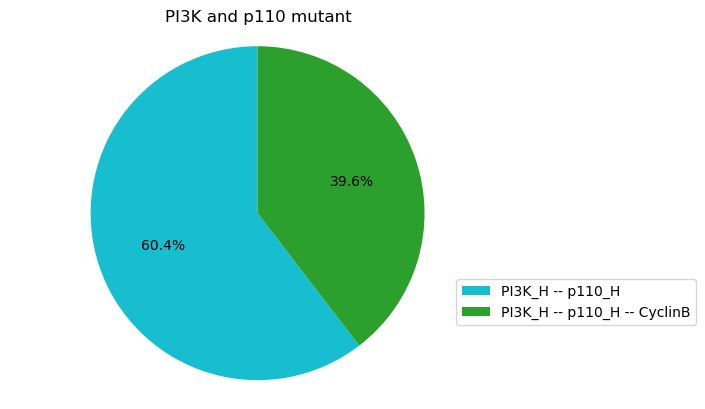

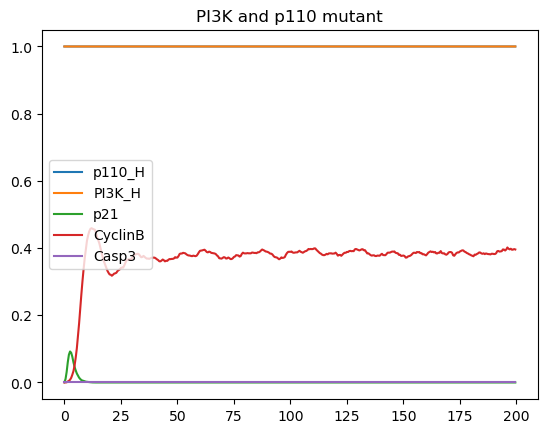

In [19]:
mut_PI3K_p110_ON = mut_PI3K_ON.copy()
mut_PI3K_p110_ON.mutate("p110_H", "ON")
mutres_PI3K_p110_ON = mut_PI3K_p110_ON.run()
mutres_PI3K_p110_ON.plot_piechart()
plt.title('PI3K and p110 mutant')
mutres_PI3K_p110_ON.get_nodes_probtraj().plot(legend=True)
plt.title('PI3K and p110 mutant')

When both PI3K_H and p110_H are forced to 1, the simulations show similar behaviour as the one obtained in experimental observations (no cytokinesis)

#### (8-9) FOXO3 knock out

Text(0.5, 1.0, 'FoxO3 mutant')

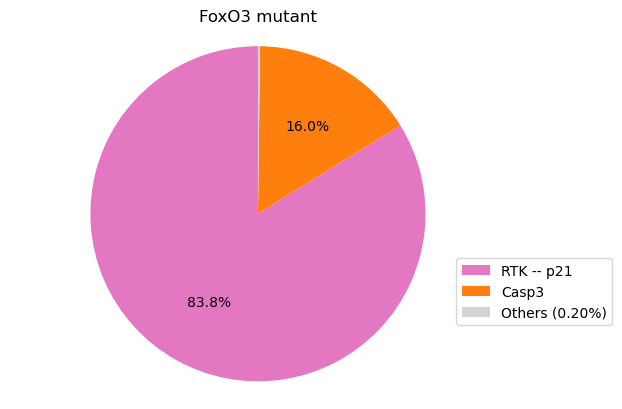

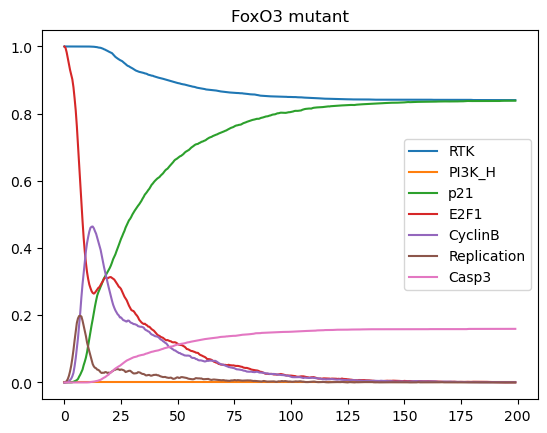

In [20]:
mut_FoxO3_OFF = WT.copy()
#maboss.set_nodes_istate(mut_FoxO3_OFF, ["GF", "GF_High","RTK", "mTORC2","PI3K","PIP3","PDK1","AKT_B","p110_H","FoxO3","FoxO1","p21_mRNA","TSC2","PRAS40","GSK3","p21","pRB","p27Kip1","Cdh1","MCL_1","BCLXL","BCL2","IAPs"], [0,1])

mut_FoxO3_OFF.mutate("FoxO3", "OFF")
mutres_FoxO3_OFF = mut_FoxO3_OFF.run()
mutres_FoxO3_OFF.plot_piechart()
plt.title('FoxO3 mutant')
mutres_FoxO3_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('FoxO3 mutant')

There seems to be one cycle and then the cycles stop. Cyclin B is activated once and degraded but there is no reactivation. It is difficult to interpret the results as no cytokinesis at all, but we can say with confidence that cells have difficulties to go through a second cycle. 

## Test sequence of cyclins

In this section, we explore the dynamics of the cell cycle by studying the succession of cyclin activation. In most of the trajectories, the cyclins activate in the proper order: CyclinE, followed by CyclinA then CyclinB, and inactivate as follows: Cyclin E is inativated, then CyclinB and finally CyclinA.

For this section, we only focus on the cyclins.

In [21]:
outputs = ["CyclinA", "CyclinB", "CyclinE"]

In [22]:
WT_death.network.set_output(outputs)

CPU times: user 0 ns, sys: 22.4 ms, total: 22.4 ms
Wall time: 2.49 s


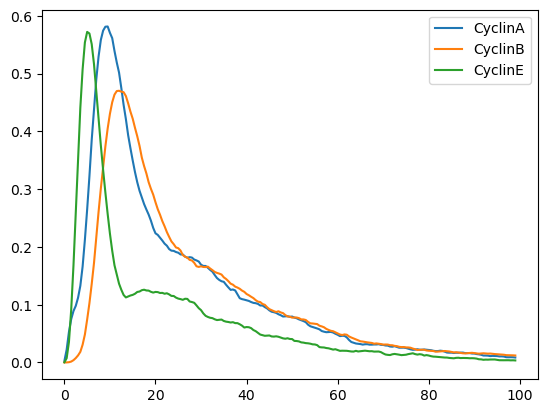

In [23]:
%time res = WT_death.run()
res.plot_node_trajectory()

We explore the dynamics in the case of the discrete simulations to compare with the initial publication and confirm the same dynamics.

In [24]:
## Discrete time
WT_death_discrete = WT_death.copy()
WT_death_discrete.update_parameters(discrete_time=1, time_tick=1, max_time=100)

In [25]:
%time res_discrete = WT_death_discrete.run()

CPU times: user 9.05 ms, sys: 8.86 ms, total: 17.9 ms
Wall time: 1.24 s


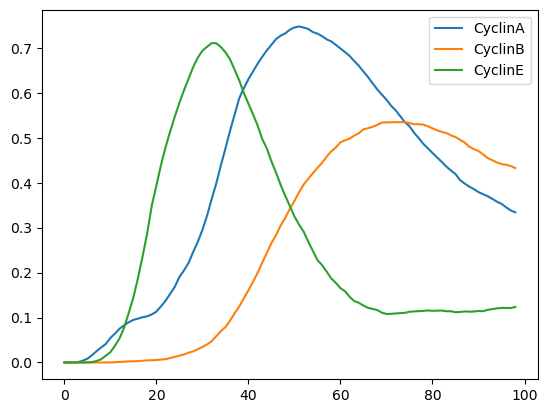

In [26]:
res_discrete.plot_node_trajectory()

### Observed state transition graph

We compute next the frequencies of the sequence of cyclin activations computed over all individual trajectories of the simulation. 

To do this, we simulate MaBoSS with the display_traj=1 option to save all the individual trajectories simulated by MaBoSS. With all these trajectories, we can count everytime we change from one state to another, thus we can reconstruct the observed state transition graph.

Note that using this mode, outputs have no effect : we get the complete trajectories, with the complete states. However, the full state transition graph would be too big to build, so we ignore transition to a node that is not an output node (in our case, the three cyclins).

In [27]:
WT_death_trajs = WT_death.copy()
WT_death_trajs.update_parameters(display_traj=1, thread_count=1)

In [28]:
%time res_trajs = WT_death_trajs.run()

CPU times: user 18.1 ms, sys: 33.1 ms, total: 51.2 ms
Wall time: 15 s


We first extract the list of trajectories, and then count the occurences

In [29]:
trajs, all_states = load_trajs(res_trajs._path, outputs, )
stg_counts, state_ids, ids_state = compute_stg_counts(trajs, all_states)

In [30]:
data = pd.DataFrame(
    data=stg_counts,
    index=state_ids.keys(), columns=state_ids.keys()
)
data

,<nil>,CyclinA,CyclinA -- CyclinB,CyclinA -- CyclinB -- CyclinE,CyclinA -- CyclinE,CyclinB,CyclinB -- CyclinE,CyclinE
<nil>,0.0,2214.0,0.0,0.0,0.0,206.0,0.0,9607.0
CyclinA,4459.0,0.0,4156.0,0.0,149.0,0.0,0.0,0.0
CyclinA -- CyclinB,0.0,1236.0,0.0,22.0,0.0,5939.0,0.0,0.0
CyclinA -- CyclinB -- CyclinE,0.0,0.0,2980.0,0.0,9.0,0.0,65.0,0.0
CyclinA -- CyclinE,0.0,5329.0,0.0,3021.0,0.0,0.0,0.0,34.0
CyclinB,6070.0,0.0,76.0,0.0,0.0,0.0,38.0,0.0
CyclinB -- CyclinE,0.0,0.0,0.0,12.0,0.0,67.0,0.0,43.0
CyclinE,1423.0,0.0,0.0,0.0,8227.0,0.0,19.0,0.0


Here we see that we exited the <nil> state around 12000 times. Most of them to activate Cyclin E

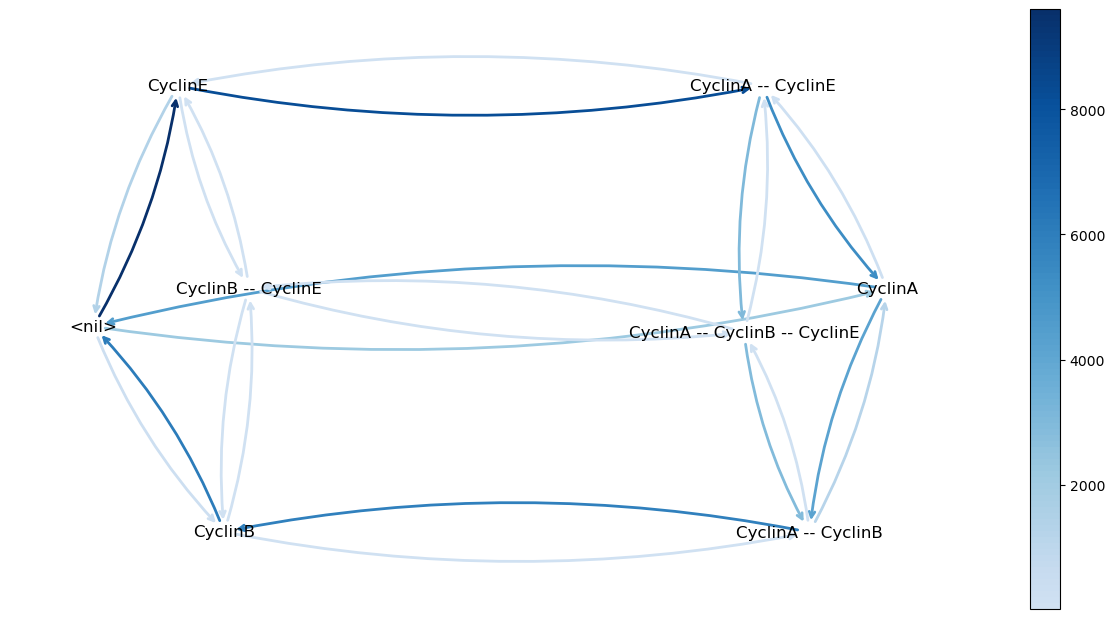

In [31]:
draw_graph_from_pandas(data)

The strongest the color, the most probable are the sequences in the simulation. We confirm here that CyclinE activates first, then CyclinA, then CyclinB. CyclinE is the first to get inactivated after CyclinB has reached its peak, followed by CyclinB and finally CyclinA. 

Next, we compute the probability of transition from each state to the next.

In [32]:
probas = pd.DataFrame(
    data=np.divide(stg_counts,stg_counts.sum(axis=1)[:, np.newaxis]), 
    index=state_ids.keys(), columns=state_ids.keys()
)
probas

,<nil>,CyclinA,CyclinA -- CyclinB,CyclinA -- CyclinB -- CyclinE,CyclinA -- CyclinE,CyclinB,CyclinB -- CyclinE,CyclinE
<nil>,0.000000,0.184086,0.000000,0.000000,0.000000,0.017128,0.000000,0.798786
CyclinA,0.508786,0.000000,0.474213,0.000000,0.017001,0.000000,0.000000,0.000000
CyclinA -- CyclinB,0.000000,0.171738,0.000000,0.003057,0.000000,0.825205,0.000000,0.000000
CyclinA -- CyclinB -- CyclinE,0.000000,0.000000,0.975769,0.000000,0.002947,0.000000,0.021284,0.000000
CyclinA -- CyclinE,0.000000,0.635615,0.000000,0.360329,0.000000,0.000000,0.000000,0.004055
CyclinB,0.981565,0.000000,0.012290,0.000000,0.000000,0.000000,0.006145,0.000000
CyclinB -- CyclinE,0.000000,0.000000,0.000000,0.098361,0.000000,0.549180,0.000000,0.352459
CyclinE,0.147171,0.000000,0.000000,0.000000,0.850864,0.000000,0.001965,0.000000


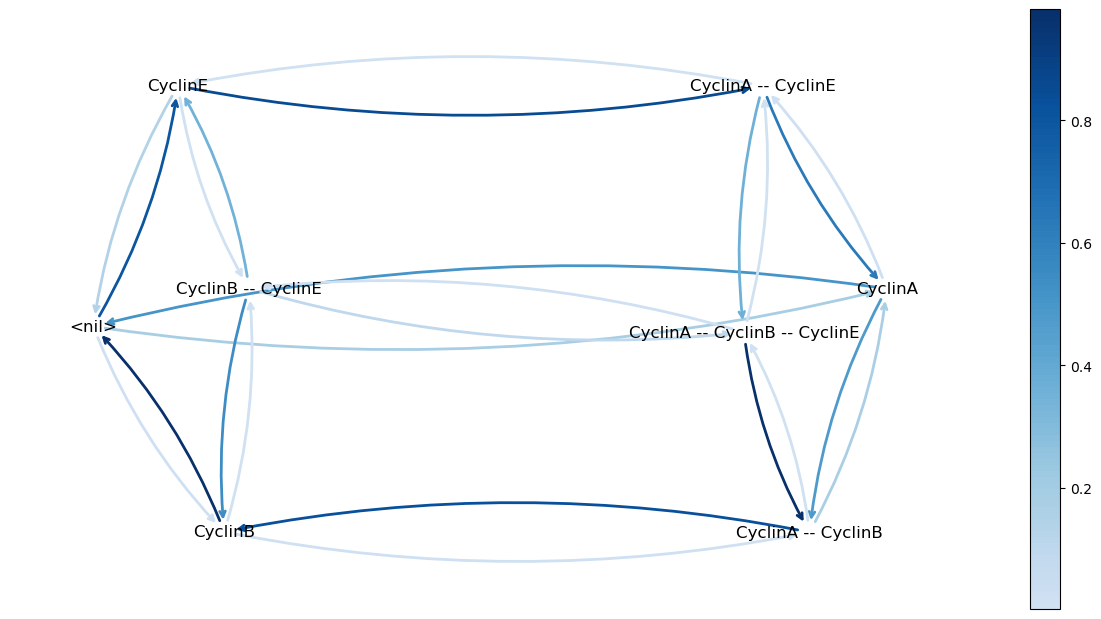

In [33]:
draw_graph_from_pandas(probas)

Using this probability matrix, we can compute the probability for each cycle

In [34]:
%time paths_dict = compute_circuits(probas, ids_state, '<nil>', 0)

CPU times: user 27.2 ms, sys: 29.6 ms, total: 56.8 ms
Wall time: 21 ms


In [35]:
for proba in sorted(paths_dict, reverse=True):
    if proba > 0.01:
        print("%.2f : %s" % (proba, paths_dict[proba]))

0.22 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA']
0.19 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA -- CyclinB -- CyclinE', 'CyclinA -- CyclinB', 'CyclinB']
0.17 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA', 'CyclinA -- CyclinB', 'CyclinB']
0.12 : ['<nil>', 'CyclinE']
0.09 : ['<nil>', 'CyclinA']
0.07 : ['<nil>', 'CyclinA', 'CyclinA -- CyclinB', 'CyclinB']
0.02 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA -- CyclinB -- CyclinE', 'CyclinA -- CyclinB', 'CyclinA']
0.02 : ['<nil>', 'CyclinB']


Here we see that the most likely cycle is a small one, only with Cyclin E and Cyclin A (22%). 
The full cycle, with all cyclins is mainly present with two possibilities : 
- Either the cyclin B is activated before inactivating cyclin E (20%)
- Or the cyclin B is activated after the inactivation of cyclin E (16%)

We also observe three cycles, were only one cyclin is activated and then inactivated (22%)
Finally, one full cycle where cyclin B is inactivated before cyclin A (2%)

In [36]:
print("By removing all loops, we are removing at %.2g%% of observed circuits" % (100.0*(1-sum(paths_dict.keys()))))

By removing all loops, we are removing at 9.6% of observed circuits



Note that we are excluding 10% of cycles, where in the middle of it one cyclin is activated then inactivated immediatly. 

### The involvement of the apoptotic pathway in the cell cycle

Here we try to study the condition leading to apoptotic death. We are trying to look for the point in the cell cycle where Casp3 is activated 

In [37]:
outputs =["Casp3", "CyclinA", "CyclinB", "CyclinE"]

WT_death.network.set_output(outputs)

CPU times: user 1.45 ms, sys: 762 µs, total: 2.22 ms
Wall time: 2.33 s


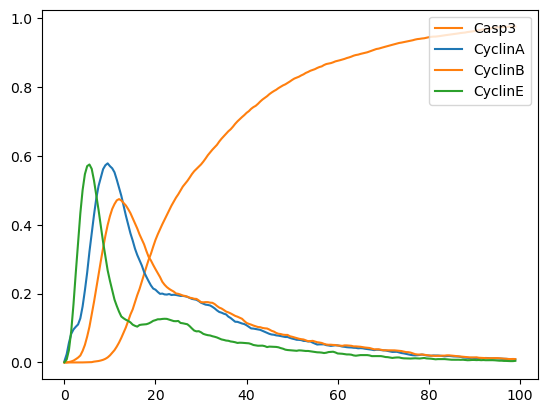

In [38]:
%time res = WT_death.run()
res.plot_node_trajectory()

We see cells starting to cycle, but quickly activating Casp3 and dying.

In [39]:
WT_death_trajs = WT_death.copy()
WT_death_trajs.update_parameters(display_traj=1, thread_count=1)

%time res_trajs = WT_death_trajs.run()


CPU times: user 23.5 ms, sys: 62 ms, total: 85.5 ms
Wall time: 14.6 s


In [40]:
%time trajs, all_states = load_trajs(res_trajs._path, outputs)
stg_counts, state_ids, ids_state = compute_stg_counts(trajs, all_states)

data = pd.DataFrame(
    data=stg_counts,
    index=state_ids.keys(), columns=state_ids.keys()
)
data


CPU times: user 3.68 s, sys: 170 ms, total: 3.85 s
Wall time: 3.84 s


,<nil>,Casp3,Casp3 -- CyclinA,Casp3 -- CyclinA -- CyclinB,Casp3 -- CyclinA -- CyclinB -- CyclinE,Casp3 -- CyclinA -- CyclinE,Casp3 -- CyclinB,Casp3 -- CyclinB -- CyclinE,Casp3 -- CyclinE,CyclinA,CyclinA -- CyclinB,CyclinA -- CyclinB -- CyclinE,CyclinA -- CyclinE,CyclinB,CyclinB -- CyclinE,CyclinE
<nil>,0.0,2264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2035.0,0.0,0.0,0.0,135.0,0.0,9468.0
Casp3,0.0,0.0,178.0,0.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinA,0.0,406.0,0.0,118.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinA -- CyclinB,0.0,0.0,108.0,0.0,0.0,0.0,832.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinA -- CyclinB -- CyclinE,0.0,0.0,0.0,24.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinA -- CyclinE,0.0,0.0,60.0,0.0,18.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinB,0.0,2301.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinB -- CyclinE,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Casp3 -- CyclinE,0.0,194.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CyclinA,4067.0,0.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3890.0,0.0,168.0,0.0,0.0,0.0


Here if we want to find the activation of Casp3, we need to look at the subgraph in the lower left of the matrix

In [41]:
import pandas
data.iloc[9:16, 1:9].append(data.iloc[0, 1:9])

/tmp/ipykernel_21637/3290459043.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data.iloc[9:16, 1:9].append(data.iloc[0, 1:9])


,Casp3,Casp3 -- CyclinA,Casp3 -- CyclinA -- CyclinB,Casp3 -- CyclinA -- CyclinB -- CyclinE,Casp3 -- CyclinA -- CyclinE,Casp3 -- CyclinB,Casp3 -- CyclinB -- CyclinE,Casp3 -- CyclinE
CyclinA,0.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0
CyclinA -- CyclinB,0.0,0.0,779.0,0.0,0.0,0.0,0.0,0.0
CyclinA -- CyclinB -- CyclinE,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
CyclinA -- CyclinE,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0
CyclinB,0.0,0.0,0.0,0.0,0.0,1397.0,0.0,0.0
CyclinB -- CyclinE,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
CyclinE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.0
<nil>,2264.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we see that around half of these activation of Casp3 happen in G0, when no cyclins are activated.

Then in the diagonal, we see the activations of Casp3 from all cyclic states.
Most of them (80%) are with Cyclin B activated, but not Cyclin E, which correspond to the end of the cell cycle.


Text(0.5, 1.0, 'FoxO3 mutant')

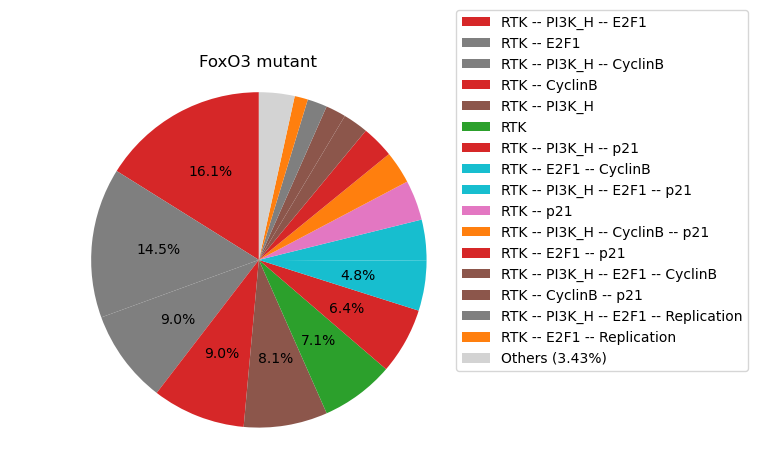

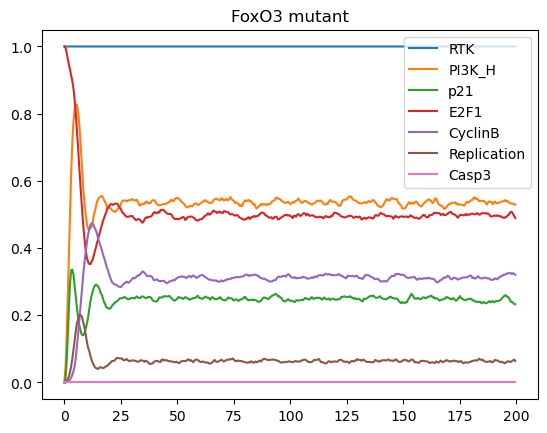

In [42]:
mut_CASP3_OFF = WT.copy()
#maboss.set_nodes_istate(mut_FoxO3_OFF, ["GF", "GF_High","RTK", "mTORC2","PI3K","PIP3","PDK1","AKT_B","p110_H","FoxO3","FoxO1","p21_mRNA","TSC2","PRAS40","GSK3","p21","pRB","p27Kip1","Cdh1","MCL_1","BCLXL","BCL2","IAPs"], [0,1])

mut_CASP3_OFF.mutate("Casp3", "OFF")
mutres_CASP3_OFF = mut_CASP3_OFF.run()
mutres_CASP3_OFF.plot_piechart()
plt.title('FoxO3 mutant')
mutres_CASP3_OFF.get_nodes_probtraj().plot(legend=True)
plt.title('FoxO3 mutant')

In [43]:
mut_CASP3_OFF_trajs = mut_CASP3_OFF.copy()
outputs = ["CyclinA", "CyclinB", "CyclinE"]
mut_CASP3_OFF_trajs.network.set_output(outputs)
mut_CASP3_OFF_trajs.update_parameters(display_traj=1, thread_count=1)

In [44]:
%time res_trajs = mut_CASP3_OFF_trajs.run()

CPU times: user 1.27 ms, sys: 36.6 ms, total: 37.9 ms
Wall time: 1min 4s


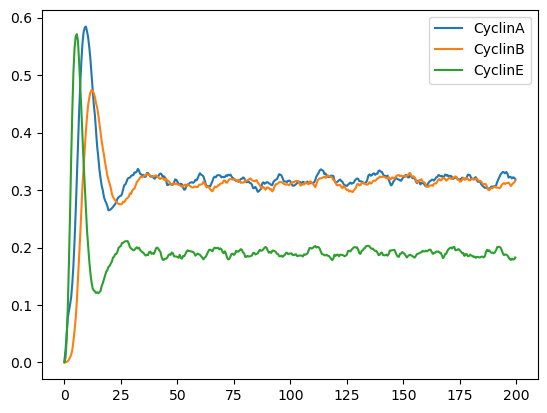

In [45]:
res_trajs.plot_node_trajectory()

In [46]:
trajs, all_states = load_trajs(res_trajs._path, outputs, )
stg_counts, state_ids, ids_state = compute_stg_counts(trajs, all_states)

In [47]:
data = pd.DataFrame(
    data=stg_counts,
    index=state_ids.keys(), columns=state_ids.keys()
)
data

,<nil>,CyclinA,CyclinA -- CyclinB,CyclinA -- CyclinB -- CyclinE,CyclinA -- CyclinE,CyclinB,CyclinB -- CyclinE,CyclinE
<nil>,0.0,10868.0,0.0,0.0,0.0,1293.0,0.0,48398.0
CyclinA,20494.0,0.0,22219.0,0.0,666.0,0.0,0.0,0.0
CyclinA -- CyclinB,0.0,5873.0,0.0,76.0,0.0,30588.0,0.0,0.0
CyclinA -- CyclinB -- CyclinE,0.0,0.0,14823.0,0.0,37.0,0.0,336.0,0.0
CyclinA -- CyclinE,0.0,27013.0,0.0,15121.0,0.0,0.0,0.0,106.0
CyclinB,31059.0,0.0,452.0,0.0,0.0,0.0,190.0,0.0
CyclinB -- CyclinE,0.0,0.0,0.0,77.0,0.0,371.0,0.0,174.0
CyclinE,6199.0,0.0,0.0,0.0,41733.0,0.0,97.0,0.0


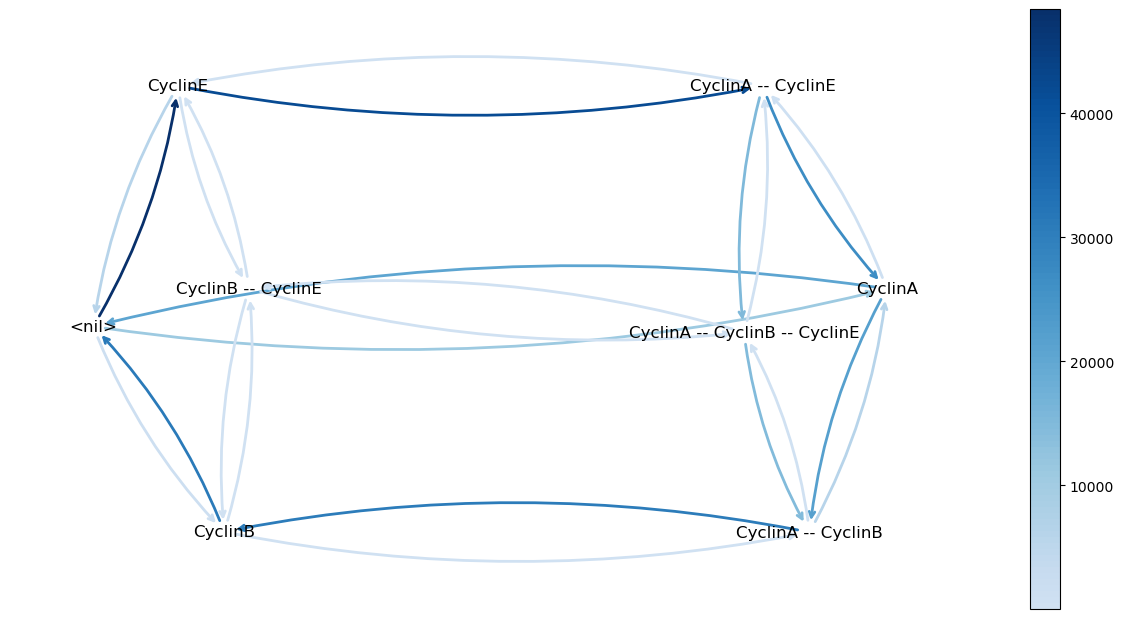

In [48]:
draw_graph_from_pandas(data)

In [49]:
probas = pd.DataFrame(
    data=np.divide(stg_counts,stg_counts.sum(axis=1)[:, np.newaxis]), 
    index=state_ids.keys(), columns=state_ids.keys()
)
probas

,<nil>,CyclinA,CyclinA -- CyclinB,CyclinA -- CyclinB -- CyclinE,CyclinA -- CyclinE,CyclinB,CyclinB -- CyclinE,CyclinE
<nil>,0.000000,0.179461,0.000000,0.000000,0.000000,0.021351,0.000000,0.799188
CyclinA,0.472441,0.000000,0.512206,0.000000,0.015353,0.000000,0.000000,0.000000
CyclinA -- CyclinB,0.000000,0.160741,0.000000,0.002080,0.000000,0.837179,0.000000,0.000000
CyclinA -- CyclinB -- CyclinE,0.000000,0.000000,0.975454,0.000000,0.002435,0.000000,0.022111,0.000000
CyclinA -- CyclinE,0.000000,0.639512,0.000000,0.357978,0.000000,0.000000,0.000000,0.002509
CyclinB,0.979748,0.000000,0.014258,0.000000,0.000000,0.000000,0.005994,0.000000
CyclinB -- CyclinE,0.000000,0.000000,0.000000,0.123794,0.000000,0.596463,0.000000,0.279743
CyclinE,0.129068,0.000000,0.000000,0.000000,0.868913,0.000000,0.002020,0.000000


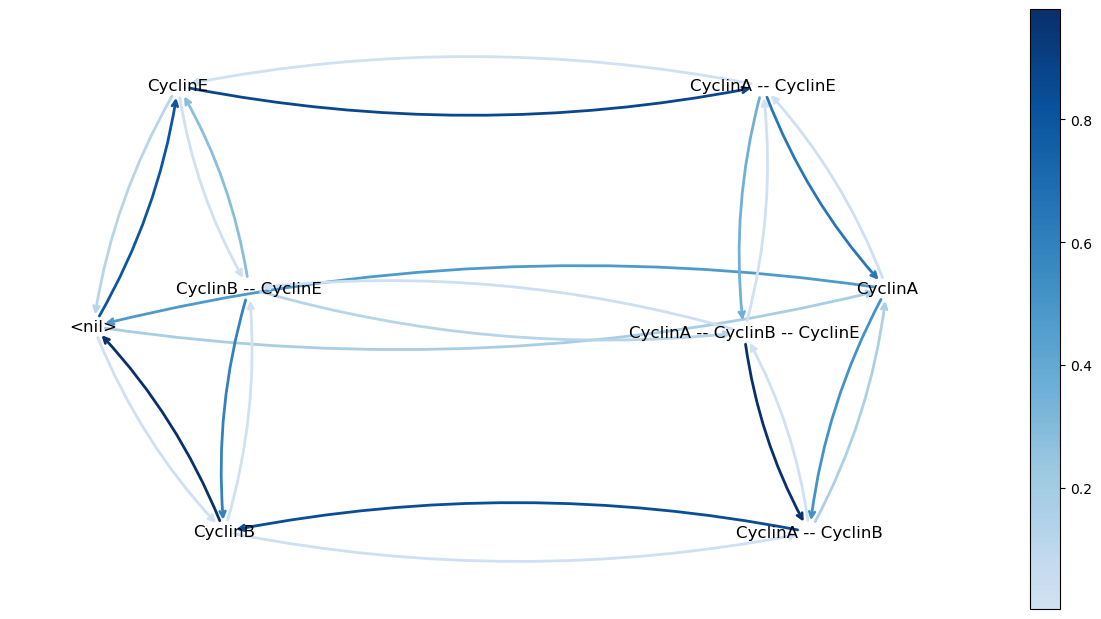

In [50]:
draw_graph_from_pandas(probas)

In [51]:
%time paths_dict = compute_circuits(probas, ids_state, '<nil>', 0)

CPU times: user 41.6 ms, sys: 31.5 ms, total: 73.1 ms
Wall time: 33.9 ms


In [52]:
for proba in sorted(paths_dict, reverse=True):
    if proba > 0.01:
        print("%.2f : %s" % (proba, paths_dict[proba]))

0.21 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA']
0.20 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA -- CyclinB -- CyclinE', 'CyclinA -- CyclinB', 'CyclinB']
0.19 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA', 'CyclinA -- CyclinB', 'CyclinB']
0.10 : ['<nil>', 'CyclinE']
0.08 : ['<nil>', 'CyclinA']
0.08 : ['<nil>', 'CyclinA', 'CyclinA -- CyclinB', 'CyclinB']
0.02 : ['<nil>', 'CyclinB']
0.02 : ['<nil>', 'CyclinE', 'CyclinA -- CyclinE', 'CyclinA -- CyclinB -- CyclinE', 'CyclinA -- CyclinB', 'CyclinA']
